In [1]:
%matplotlib inline
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

## Screenshot from the oscilloscope
This screenshot shows the entire duration of the command `make VERSION=v1 infer`. The data that we will be using from the CSV corresponds to the second peak and each peak corresponds to one inference. Since the first one initialises some data structures that will be reused in the upcoming inferences, we discard it because usually we would not be performing a single analysis. 

![2x inferences](measurements/v1/2x_inferences.png)

## Output

In [2]:
! cat measurements/v1/output.txt

pi@raspberrypi:~/oscw18-edge-ai/movidius $ make VERSION=v1 infer INPUT=data/pic_002.jpg 

Running inferences on data/pic_002.jpg...
(python3 image-classifier.py --graph ./model/v1/inception_v1_ncgraph --dim 224 224 --mean 127.5 --scale 0.00789 --colormode "RGB" --labels ./model/v1/labels.txt --image data/pic_002.jpg)

Top predictions for pic_002.jpg
Execution time: 88.4408ms
--------------------------------------------------------------
73.8%   288:lynx, catamount
8.3%    283:tiger cat
4.9%    282:tabby, tabby cat
4.3%    284:Persian cat
1.2%    286:Egyptian cat


## Parse raw data 

In [3]:
df_params = pd.read_csv("measurements/v1/second_inference.csv", nrows=1, usecols=['Start', 'Increment'])
period_ms = df_params['Increment'][0] * 1000
period_ms

0.1

In [4]:
df_val = pd.read_csv("measurements/v1/second_inference.csv", skiprows=[1], usecols=['X', 'CH1', 'CH2'])
df_val.loc[:, 'X'] *= period_ms

# probes were in 10x scale, scope in 1x
df_val.loc[:, 'CH1'] *= 10
df_val.loc[:, 'CH2'] *= 10

df_val.rename(index=str, columns={'X': 'time [ms]', 'CH1': 'vout [V]', 'CH2': 'vin [V]'}, inplace=True)
df_val[:10]

,time [ms],vout [V],vin [V]
0,0.0,4.86,5.27
1,0.1,4.90,5.32
2,0.2,4.90,5.28
3,0.3,4.86,5.32
4,0.4,4.89,5.32
5,0.5,4.86,5.27
6,0.6,4.86,5.32
7,0.7,4.89,5.28
8,0.8,4.86,5.32
9,0.9,4.89,5.27


# Obtaining power consumption

In [5]:
R = 1 # ohm
df_val['curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R
df_val['curr [mW]'] = df_val['curr [mA]'] * df_val['vout [V]']
df_val[:10]
# TODO subtract "static current"

,time [ms],vout [V],vin [V],curr [mA],curr [mW]
0,0.0,4.86,5.27,410.0,1992.6
1,0.1,4.90,5.32,420.0,2058.0
2,0.2,4.90,5.28,380.0,1862.0
3,0.3,4.86,5.32,460.0,2235.6
4,0.4,4.89,5.32,430.0,2102.7
5,0.5,4.86,5.27,410.0,1992.6
6,0.6,4.86,5.32,460.0,2235.6
7,0.7,4.89,5.28,390.0,1907.1
8,0.8,4.86,5.32,460.0,2235.6
9,0.9,4.89,5.27,380.0,1858.2


Text(0.5,1,'Power')

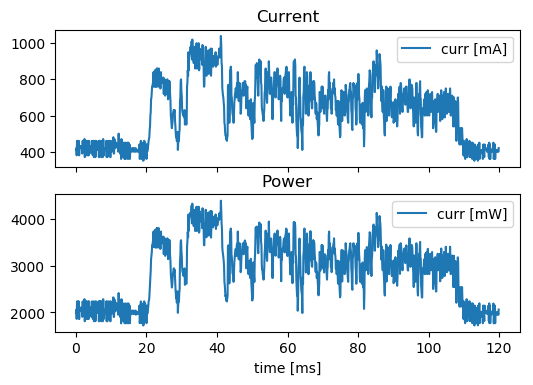

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=100)

df_val.plot(ax=ax1, x='time [ms]', y='curr [mA]')
ax1.set_title("Current")
df_val.plot(ax=ax2, x='time [ms]', y='curr [mW]')
ax2.set_title("Power")

## Obtaining total energy consumption

In [7]:
energy = df_val['curr [mA]'].sum() * period_ms # mA*ms
energy /= (1000 * 3600) # mAh
energy

0.021083055555555567